# Demo 6: SVM for MNIST Digit Recognition

In this demo, you will learn to:
* Load and display images
* Formulate image classification problems
* Explain the limitations of linear classifiers for image classification
* Build a simple SVM image classifier 
* Save and load results using `pickle`.

For data, we will use the classic [MNIST](https://en.wikipedia.org/wiki/MNIST_database) data set used to recognize hand-written digits.  The dataset was originally produced in the 1980s and is now widely-used in machine learning classes as a simple image classification problem.  

## Loading the Data

First, we load the standard packages.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
%matplotlib inline

Since the MNIST dataset is so widely-used, it comes in as a build-in dataset in many packages. In this lab, we will download the data from the Tensorflow package -- See here for [installations instructions](https://www.tensorflow.org/install).  You can get the data from other sources as well. 

In the Tensorflow dataset, the training and test data are represented as arrays:

     Xtr.shape = 60000 x 28 x 28
     Xts.shape = 10000 x 28 x 28
     
The test data consists of `60000` images of size `28 x 28` pixels; the test data consists of `10000` images.

In [2]:
import tensorflow as tf

(Xtr,ytr),(Xts,yts) = tf.keras.datasets.mnist.load_data()

print('Xtr shape: %s' % str(Xtr.shape))
print('Xts shape: %s' % str(Xts.shape))

ntr = Xtr.shape[0]
nts = Xts.shape[0]
nrow = Xtr.shape[1]
ncol = Xtr.shape[2]

Xtr shape: (60000, 28, 28)
Xts shape: (10000, 28, 28)


Each pixel value is from `[0,255]`.  For this lab, it will be convenient to recale the value to -1 to 1 and reshape it as a `ntr x npix` and `nts x npix`.

In [3]:
npix = nrow*ncol
Xtr = 2*(Xtr/255 - 0.5)
Xtr = Xtr.reshape((ntr,npix))

Xts = 2*(Xts/255 - 0.5)
Xts = Xts.reshape((nts,npix))

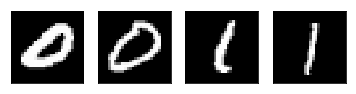

In [4]:
def plt_digit(x):
    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    plt.imshow(xsq,  cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])

# Select random digits
nplt = 4
Iperm = np.random.permutation(ntr)

# Plot the images using the subplot command
for i in range(nplt):
    ind = Iperm[i]
    plt.subplot(1,nplt,i+1)
    plt_digit(Xtr[ind,:])

## Run an SVM classifier

We now try an SVM classifier.  The parameters are given by 

https://martin-thoma.com/svm-with-sklearn/

This website has a nice summary of the main equations for SVM as well.  That site trained on 40000 samples and tested on 20000.  But, to make this run faster, we will train on 10000 and test on 10000.  If you increase to 40000 training samples, you can get past 99% accuracy.

First, we import the SVM package and construct the SVC with the parameters.

## First let us try the linear kernel

In [5]:
from sklearn import svm

# Create a classifier: a support vector classifier
svc = svm.SVC(probability=False,  kernel="linear", C=2.8, verbose=10)

Next, we get the training and test data.  The features are re-scaled to be between -1 and 1.

We fit the training data.  Again, this will take several minutes.

In [6]:
len(Xtr)

60000

In [7]:
ntr1 = 5000
nts1 = 5000
Iperm = np.random.permutation(list(range(len(Xtr))))
Iperm_ts = np.random.permutation(list(range(len(Xts))))
Xtr1 = Xtr[Iperm[:ntr1],:]
ytr1 = ytr[Iperm[:ntr1]]
Xts1 = Xts[Iperm_ts[:nts1],:]
yts1 = yts[Iperm_ts[:nts1]]

In [8]:
start_time = time.time()
svc.fit(Xtr,ytr)
print("takes {0} seconds to fit linear svm".format(time.time()-start_time))

[LibSVM]takes 596.6586833000183 seconds to fit linear svm


Measure the accuracy on the test data.  The prediction can take several minutes too -- SVMs are *very* slow!

In [9]:
start_time = time.time()
yhat_ts = svc.predict(Xts1)
print("takes {0} seconds for linear svm to predict".format(time.time()-start_time))

takes 38.27939009666443 seconds for linear svm to predict


In [10]:
acc = np.mean(yhat_ts == yts1)
print('Accuaracy = {0:f}'.format(acc))

Accuaracy = 0.933400


You should get an accuracy of around 93%.  Again, had you trained on all 50,000 samples, it would have been much better -- close to 98.5%.  But, even this result is much better than logistic regression.

## Looking at the Support Vectors

Let's take a look at the support vectors.  We see there about over 2500 support vectors.  So, about quarter the training samples were used as SVs.  This is partly why the prediction was so slow.

In [11]:
S = svc.support_vectors_
S.shape

(10124, 784)

Let us plot some support vectors

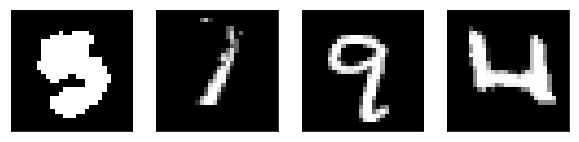

In [12]:
nplt = 4
nsv = S.shape[0]
Iperms = np.random.permutation(nsv)
plt.figure(figsize=(10, 4))
for i in range(nplt):        
    plt.subplot(1,nplt,i+1)        
    ind = Iperms[i]
    plt_digit(S[ind,:])   

We see that the support vectors look like digits we want to recognize. They are like the 'match filters'.

## Now let us see the performanc of SVM using the RBF kernel

In [13]:
# Create a classifier: a support vector classifier
svcrbf = svm.SVC(probability=False,  kernel="rbf", C=2.8, gamma=.0073,verbose=10)

In [14]:
# Can skip this step if loading from previous result 
start_time = time.time()
svcrbf.fit(Xtr1,ytr1)   
print("takes {0} seconds to fit a rbf svm".format(time.time()-start_time))

[LibSVM]takes 12.5977201461792 seconds to fit a rbf svm


In [15]:
# skip if load from saved result
start_time=time.time()
yhat_ts = svcrbf.predict(Xts1)
print("takes {0} seconds for rbf svm to predict".format(time.time()-start_time))

takes 12.31489086151123 seconds for rbf svm to predict


In [16]:
acc = np.mean(yhat_ts == yts1)
print('Accuaracy = {0:f}'.format(acc))

Accuaracy = 0.964600


We see that the RBF kernel provides more accurate results. 
Now let us plot some errors

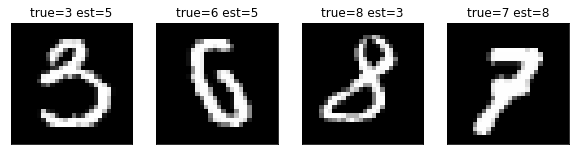

In [17]:
Ierr = np.where((yhat_ts != yts1))[0]
nplt = 4
plt.figure(figsize=(10, 4))
for i in range(nplt):        
    plt.subplot(1,nplt,i+1)        
    ind = Ierr[i]    
    plt_digit(Xts1[ind,:])        
    title = 'true={0:d} est={1:d}'.format(yts1[ind].astype(int), yhat_ts[ind].astype(int))
    plt.title(title)

We see that again a human would not have made these errors, but the digits in error are much less clear.

## Looking at the Support Vectors

Let's take a look at the support vectors.  We see there about 5000 support vectors.  So, about half the training samples were used as SVs, more than that for the linear kernel.  This is partly why the prediction was so slow.

In [18]:
S = svcrbf.support_vectors_
S.shape

(3058, 784)

We can plot some of the vectors.

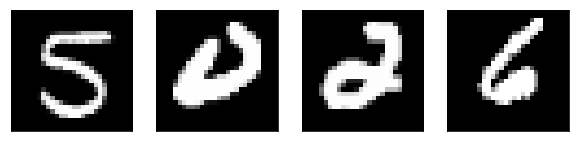

In [19]:
nplt = 4
nsv = S.shape[0]
Iperms = np.random.permutation(nsv)
plt.figure(figsize=(10, 4))
for i in range(nplt):        
    plt.subplot(1,nplt,i+1)        
    ind = Iperms[i]
    plt_digit(S[ind,:])        